In [1]:
!pip install h5PY
!pip install gudhi


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\octav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\octav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import matplotlib.pyplot as plt

import gudhi as gd

from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
import numpy as np

import scipy

import os



# TP3: Reconnaissance de signaux de communication par apprentissage profond 

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb 

2 séances de TP sur ce sujet : le 5 novembre (1h00), le 12 novembre (3h). 
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br> 
Deadline pour le rendu du TP: 26 novembre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur 
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie 
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié. 

L'émetteur peut provenir de 6 catégories différentes. 
Les paramètres différenciant les différentes catégories sont 
- le type de modulation 
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données 
- le débit de la transmission 

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0. 


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation 
électromagnétique comme : 
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données). 
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont: 

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet. 
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones". 

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données : 
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones 
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage 
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [3]:
data_path = r'C:\Users\octav\Documents\Cours\MVA\Apprentissage pour signaux\TP3\Database\samples.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

In [4]:
print(f'signals.shape\t:\t{signals.shape}')
print(f'snr.shape\t:\t{snr.shape}')
print(f'labels_id.shape\t:\t{labels_id.shape}')

signals.shape	:	(200, 2048, 2)
snr.shape	:	(200,)
labels_id.shape	:	(200,)


Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [5]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

In [6]:
data = h5py.File(data_path , 'r')

labels = get_labels(data)

data.close()

labels

{np.int64(1): 'N-PSK8',
 np.int64(0): 'N-QAM16',
 np.int64(2): 'N-QPSK',
 np.int64(4): 'W-PSK8-V1',
 np.int64(5): 'W-PSK8-V2',
 np.int64(3): 'W-QAM16'}

### Visualisation des données 

Commencez par étudier les données: 

    - observez leur taille 
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement 
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez 

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering 

In [7]:

def plot_signal(signal):
    t = np.arange(len(signal))
    x = signal[:,0]
    y = signal[:,1]

    # Create a new figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D point cloud (scatter)
    ax.scatter(t, x, y, c=t, cmap='viridis', s=30)

    # Label the axes
    ax.set_xlabel('t')
    ax.set_ylabel('x(t)')
    ax.set_zlabel('y(t)')

    # Optional: customize the view angle
    ax.view_init(elev=30, azim=45)



In [8]:
def compute_spectrogram(signal              :   np.ndarray,
                        window_time_size    :   float,
                        sampling_frequency  :   float)-> tuple[np.ndarray, np.ndarray, np.ndarray] :
    
    window_sample_size = sampling_frequency*window_time_size

    
    frequencies, time, short_time_fourier_transform = scipy.signal.stft(signal,
                                                                        fs = sampling_frequency,
                                                                        nperseg = window_sample_size,
                                                                        # nfft = window_sample_size,
                                                                        )
    
    # The spectrogram is defined as the squared module of the short time fourier transform
    spectrogram = np.abs(short_time_fourier_transform)**2

    return frequencies, time, spectrogram

def plot_spectrogram(signal                 :   np.ndarray,
                     window_time_size       :   float,
                     sampling_frequency     :   float,
                     log                    :   bool        =   False,
                     frequency_upper_bound  :   float       =   None) -> None:
    
    frequencies, time, spectrogram = compute_spectrogram(signal, window_time_size, sampling_frequency)

    if frequency_upper_bound is None:
        frequency_upper_bound = np.max(frequencies)

    frequencies = frequencies[frequencies<frequency_upper_bound]
    spectrogram = spectrogram[:len(frequencies),:]

    log_mes = ''
    if log:
        log_mes = 'log-'
        spectrogram = np.log10(spectrogram)

    plt.pcolor(time, frequencies, spectrogram)
    plt.title(f'{log_mes}spectrogram')
    plt.xlabel('t (s)')
    plt.ylabel('f (Hz)')
    plt.colorbar(label = f'{log_mes}value')

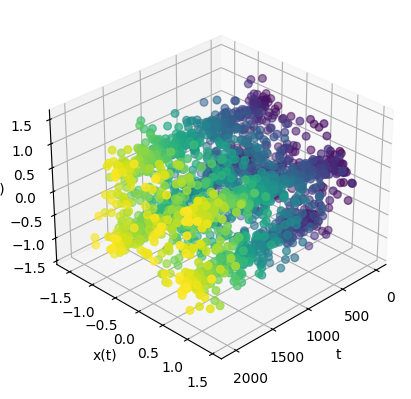

In [9]:
idx = 7

plot_signal(signal = signals[idx])


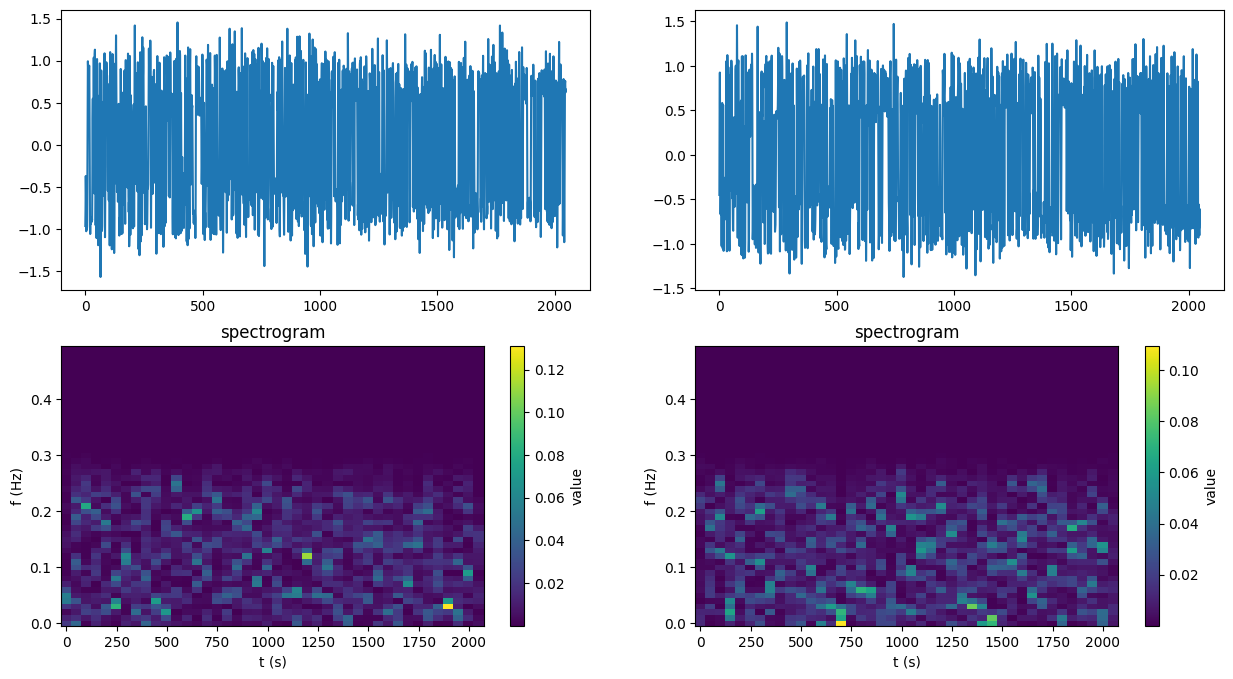

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.plot(range(len(signals[idx])), signals[idx,:,0])
plt.subplot(222)
plt.plot(range(len(signals[idx])), signals[idx,:,1])
plt.subplot(223)
plot_spectrogram(signal=signals[idx,:,0], 
                 window_time_size=100,
                 sampling_frequency=1)

plt.subplot(224)
plot_spectrogram(signal=signals[idx,:,1], 
                 window_time_size=100,
                 sampling_frequency=1)
plt.show()

In [11]:
augmented_signal = np.array([[t, signals[idx,t,0], signals[idx,t,1]] for t in range(len(signals[idx]))])
augmented_signal.shape

(2048, 3)

[(0, (0.0, inf))]


C:\Users\octav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gudhi\persistence_graphical_tools.py:139: UserWarning: usetex mode requires ghostscript.
  warnings.warn("usetex mode requires ghostscript.")


<Axes: title={'center': 'Persistence barcode'}>

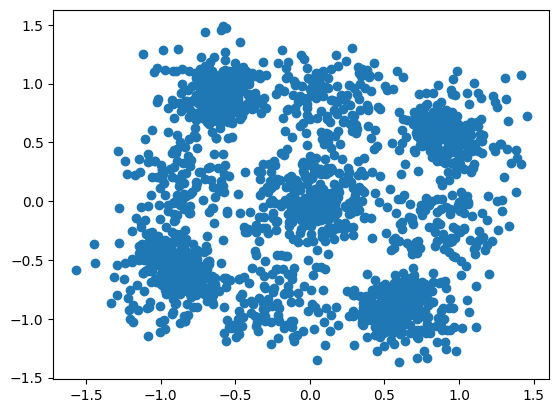

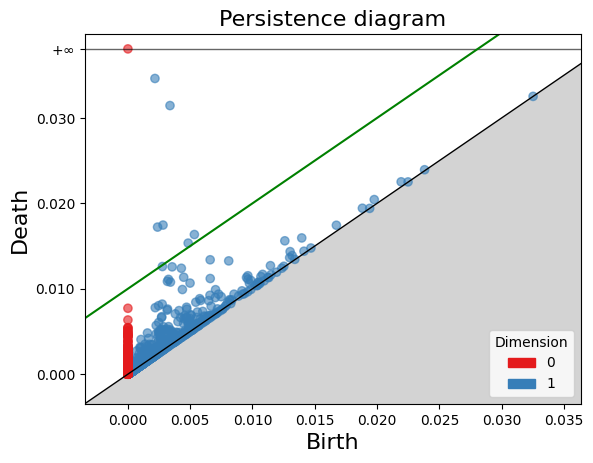

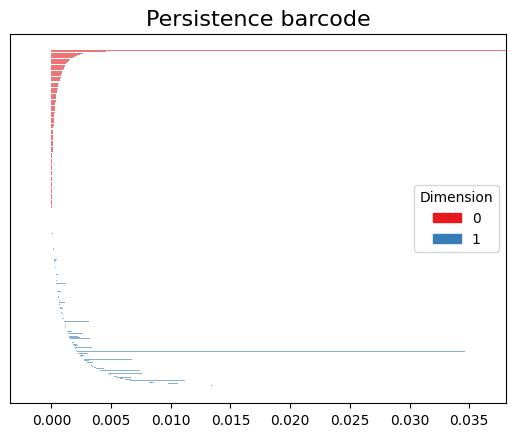

In [12]:
plt.figure()
plt.scatter(x = signals[idx, :, 0], y = signals[idx, :, 1])


cplx = gd.AlphaComplex(points=signals[idx]).create_simplex_tree()


p = cplx.persistence()
# print only the most persistent features
N = np.linspace(-1, 1, 100)
print([(dim,(birth,death)) for (dim,(birth,death)) in p if (death - birth > .01)&(dim == 0)])
gd.plot_persistence_diagram(p, legend=True)
plt.plot(N, [x + 0.01 for x in N ], color = 'g')

gd.plot_persistence_barcode(p)



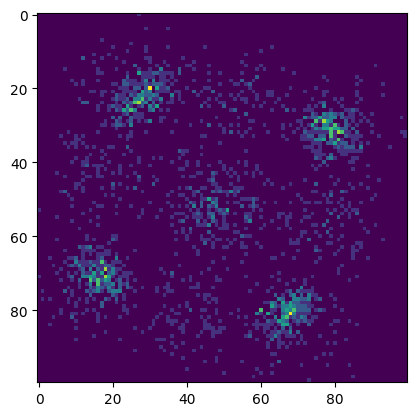

In [13]:
a, b, c = np.histogram2d(signals[idx, :, 0], signals[idx, :, 1], bins = 100)

plt.imshow(a)

## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch. 
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets : 
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones 
    
Un dataset prend la forme 
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici 

In [14]:
class DumbDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 path_to_data,
                 ):
        super().__init__()

        
        data = h5py.File(path_to_data , 'r')

        self.signals = np.array(data['signaux'])
        self.snr =  np.array(data['snr'])
        self.labels_id = np.array(data['labels'])
        self.labels_lookup_table = get_labels(data)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, i):
        signal = torch.tensor(self.signals[i])
        snr = torch.tensor(self.snr[i])
        label_id = torch.tensor(self.labels_id[i])
        return [signal, snr, label_id]

    

In [15]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 path_to_data,
                 bins = 100,
                 window_time_size=100,
                 sampling_frequency=1):
        
        super().__init__()

        
        data = h5py.File(path_to_data , 'r')


        self.signals = np.array(data['signaux'])
        self.snr =  np.array(data['snr'])
        self.labels_id = np.array(data['labels'])
        self.labels_lookup_table = get_labels(data)

        self.signals_hist_2D = []
        self.signals_spectrograms_x = []
        self.signals_spectrograms_y = []
        for signal in self.signals:

            signal_hist_2D, _, _ = np.histogram2d(signals[idx, :, 0], signals[idx, :, 1], bins = bins)
            self.signals_hist_2D.append(signal_hist_2D)

            _, _, spectrogram_x = compute_spectrogram(signal=signal[:,0],
                                                      window_time_size=window_time_size,
                                                      sampling_frequency=sampling_frequency)
            self.signals_spectrograms_x.append(spectrogram_x)
            
            _, _, spectrogram_y = compute_spectrogram(signal=signal[:,1],
                                                      window_time_size=window_time_size,
                                                      sampling_frequency=sampling_frequency)
            self.signals_spectrograms_y.append(spectrogram_y)




    def __len__(self):
        return len(self.signals)

    def __getitem__(self, i):
        signal = torch.tensor(self.signals[i], dtype = torch.float64)
        snr = torch.tensor(self.snr[i], dtype = torch.float64)
        label_id = torch.tensor(self.labels_id[i], dtype = torch.float64)

        hist_2D = torch.tensor(self.signals_hist_2D[i], dtype = torch.float64)
        spectrograms = torch.stack([torch.tensor(self.signals_spectrograms_x[i], dtype = torch.float64), torch.tensor(self.signals_spectrograms_y[i], dtype = torch.float64)])

        return [signal, hist_2D, spectrograms, snr, label_id]

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [16]:
dataset = DumbDataset(path_to_data= data_path)

In [17]:
dataset[0]

[tensor([[-0.1976,  0.8025],
         [-0.7085,  0.3194],
         [-0.9445,  0.1932],
         ...,
         [-1.2746,  0.5726],
         [-0.1521,  1.0611],
         [ 0.3594,  0.1143]]),
 tensor(10, dtype=torch.int16),
 tensor(2, dtype=torch.int8)]

In [18]:
augmented_dataset = AugmentedDataset(path_to_data= data_path)
augmented_dataset[0]

[tensor([[-0.1976,  0.8025],
         [-0.7085,  0.3194],
         [-0.9445,  0.1932],
         ...,
         [-1.2746,  0.5726],
         [-0.1521,  1.0611],
         [ 0.3594,  0.1143]], dtype=torch.float64),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([[[2.4014e-04, 8.1115e-03, 1.4158e-02,  ..., 1.2525e-02,
           3.8822e-02, 1.5390e-02],
          [4.6521e-04, 2.1251e-02, 1.2192e-02,  ..., 1.0755e-02,
           1.9352e-02, 1.2952e-02],
          [2.3265e-03, 3.0610e-02, 6.9301e-03,  ..., 7.8362e-03,
           1.4827e-02, 9.8141e-03],
          ...,
          [6.5423e-05, 6.5855e-04, 7.3549e-04,  ..., 8.2175e-04,
           3.0015e-03, 6.3307e-04],
          [2.9749e-04, 3.0036e-03, 4.9770e-04,  ..., 9.6003e-04,
           2.2438e-03,

Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset. 
La cellule suivante donne un exemple d'utilisation

In [19]:
# def collate_fn(raw_batch):
#     print(raw_batch)
#     return raw_batch

In [20]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, 
                        batch_size=10, 
                        shuffle=True,
                        #collate_fn=collate_fn
                       )

augmented_dataloader = DataLoader(augmented_dataset, 
                        batch_size=10, 
                        shuffle=True,
                        #collate_fn=collate_fn
                       )

Testez le dataloader pour différentes valeurs de batch_size 

In [21]:
for batch in dataloader:
    print(f'batched signals size \t:\t{batch[0].size()}')
    print(f'batched snr size \t:\t{batch[1].size()}')
    print(f'batched label size \t:\t{batch[2].size()}')
    break

for batch in augmented_dataloader:
    for i in range(len(batch)):
        print(f'batch[{i}].size \t:\t{batch[i].size()}')
        
    break

batched signals size 	:	torch.Size([10, 2048, 2])
batched snr size 	:	torch.Size([10])
batched label size 	:	torch.Size([10])
batch[0].size 	:	torch.Size([10, 2048, 2])
batch[1].size 	:	torch.Size([10, 100, 100])
batch[2].size 	:	torch.Size([10, 2, 51, 42])
batch[3].size 	:	torch.Size([10])
batch[4].size 	:	torch.Size([10])


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier). 

Ce modèle doit comporter moins de 10000 paramètres libres. 

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [22]:
class DumbModel(torch.nn.Module):
    def __init__(self,
                 signal_shape = (2048, 2)):
        super().__init__()

        self.operations = torch.nn.ModuleList([

            torch.nn.Conv1d(in_channels     =signal_shape[1],
                            out_channels    =5,
                            kernel_size     =15,
                            stride          = 8),

            torch.nn.ReLU(),

            torch.nn.Conv1d(in_channels     =5,
                            out_channels    =10,
                            kernel_size     =15,
                            stride          = 8),

            torch.nn.ReLU(),

            torch.nn.Conv1d(in_channels     =10,
                            out_channels    =15,
                            kernel_size     =15,
                            stride          = 8),

            torch.nn.ReLU(),

            torch.nn.Conv1d(in_channels     =15,
                            out_channels    =25,
                            kernel_size     =15,
                            stride          = 4),

            torch.nn.Softmax()
        ])

    def forward(self, signal):
        z = signal
        for operation in self.operations:
            z = operation(z)
        
        return z


Instanciez votre modèle et testez la consistence des dimensions de ses entrées et de ses sorties vis à vis des données étudiées. Il s'agit d'un test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point.

In [23]:
baseline = DumbModel()

Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante : 

In [24]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [25]:
count_n_param(baseline)

8830

## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à 
- charger les données 
- les batcher 
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires 

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs. 

In [26]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


baseline = DumbModel()

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

SyntaxError: invalid syntax (4273755983.py, line 9)

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction 
```python
modele = torch.load(...) 
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou si vous avancez suffisamment vite plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement. 
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps, si vous le souhaitez vous pouvez tenter de mettre en place des stratégies autour de l'utilisation des données d'entraînement pour améliorer vos résultats. Si vous cherchez à mettre en place de l'augmentation de données vous pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch. 

## Synthèse de résultats 

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec. 